# Refine Round 3

Now we've done a couple of rounds of annotation let's create a dataset to test accuracy.

In [1]:
%cd ..

/home/bookfinder


In [2]:
import numpy as np
import pandas as pd

from datasets import Dataset

from sentence_transformers.losses import CosineSimilarityLoss

from setfit import SetFitModel, SetFitTrainer

from pathlib import Path

# Train the model

## Read in existing annotations

In [3]:
dir_annotations = Path('data/00_annotations/03_book_binary/')

[x.name for x in dir_annotations.glob('*.jsonl')]

['hnbook_classify.jsonl', 'hnbook_binary_02.jsonl', 'hnbook_binary_03.jsonl']

In [4]:
df_in = pd.concat([
    pd.read_json(path, lines=True)
    for path in dir_annotations.glob('*.jsonl')])

In [5]:
counts = df_in.answer.value_counts()
counts

reject    312
accept     60
ignore     16
Name: answer, dtype: int64

## Stratified Sample

Create a 1:1 sample of reject and accept

In [6]:
n_sample = counts.loc[['reject', 'accept']].min()

n_sample

60

In [7]:
df_train = (
    df_in
    .query('answer != "ignore"')
    .groupby('answer', group_keys=False)
    .apply(lambda x: x.sample(min(len(x), n_sample)))
)

df_train.answer.value_counts()

accept    60
reject    60
Name: answer, dtype: int64

## Train the model

We'll use [SetFit](https://huggingface.co/blog/setfit) which is fast and good for few-shot text classification like this.

In [8]:
train_dataset = Dataset.from_pandas(df_train)
train_dataset

Dataset({
    features: ['text', 'meta', '_input_hash', '_task_hash', 'label', '_view_id', 'answer', '_timestamp', '__index_level_0__'],
    num_rows: 120
})

Use `all-MiniLM-L6-v2` which is very fast, while still quite accurate (based on the SentenceTransformers [benchmarks](https://www.sbert.net/docs/pretrained_models.html)).

In [9]:
model = SetFitModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


We'll leave all these as their default

In [10]:
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=None,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for constrastive learning
    column_mapping={"text": "text", "answer": "label"} # Map dataset columns to text/label expected by trainer

)

In [11]:
trainer.train()

Applying column mapping to training dataset
***** Running training *****
  Num examples = 4800
  Num epochs = 1
  Total optimization steps = 300
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

In [12]:
model.save_pretrained('data/06_models/setfit_2')

# Predict

Now let's evaluate our trained model on our data to evaluate.

We'll use a bucket we haven't tried before, 3.

In [13]:
df = (
    pd.read_parquet('data/02_intermediate/hn_enriched.parquet')
    .query('bucket==3 & text_length > 0')
)

len(df)

37049

In [14]:
text = df.clean_text.to_list()

Get the column corresponding to 'accept'

In [15]:
model.model_head.classes_

array(['accept', 'reject'], dtype='<U6')

In [16]:
accept_idx = list(model.model_head.classes_).index('accept')
accept_idx

0

Calculate the accept probabilities

In [17]:
%%time
probs = model.predict_proba(text)[:,accept_idx]

CPU times: user 48.4 s, sys: 2.73 s, total: 51.1 s
Wall time: 26.6 s


In [18]:
df['prob'] = probs

## Check the results

In [19]:
pd.options.display.max_colwidth = 1000

In [20]:
df.sort_values('prob', ascending=False)[['clean_text']][:10]

,clean_text
id,
28843194,"For a good read on Lepanto and context, I recommend Empires of the Sea: The Siege of Malta, the Battle of Lepanto, and the Contest for the Center of the World: https://smile.amazon.com/Empires-Sea-Battle-Lepanto-Contest/dp/0812977645/ref=sr_1_4"
27660098,"> 2) Elements of Information Theory by Joy Thomas and Thomas Cover is a thorough and engaging textbook.\n\nThomas & Cover is THE textbook on information theory -- no doubt -- but you and I have very different definitions of engaging.\n\nFor a different kind of engaging, I would recommend Dave MacKay's ""Information Theory, Inference, and Learning Algorithms"", which can be found on his website:\n\nhttp://www.inference.org.uk/mackay/itila/book.html"
29060561,"This list is from my Steam library, however I haven't yet played all of them:\n\n - Deponia \n - The Detail\n - State of Mind\n - Black Mirror II\n - The Dark Eye: Chains of Satinav\n - Disturbed\n - Earthshine\n - Edge of Reality\n - Edna & Harvey: Harvey's New Eyes\n - Fighting Fantasy Classics\n - The Forest of Doom\n - Jericho's Prophecies\n - Memoria\n - Mirt. Tales of the Cold Land\n - Scarlet Hollow - Episode 1\n - Agatha Christie - The ABC Murders\n - Life is Strange\n - Life is Strange: Before the Storm\n - The Lion's Song\n - Misadventures of Laura Silver\n - Omen Exitio: Plague\n - Syberia\n - Syberia II\n - Wonderlust"
27643869,"Written some 60 years ago, Information Theory and Coding by Abramson[1] is an absolute gem for those looking to get into info theory. The cover book [2] being the more complete resource (and somewhat of a grad level defacto standard text).\n\n[1] https://www.amazon.com/Information-Theory-Coding-Norman-Abramson/dp/B0000CHBOA\n\n[2]\nhttps://www.amazon.com/Elements-Information-Theory-Telecommunications-Processing/dp/0471241954"
29031635,Cf. 'The Myth of Mental Illness' by Thomas Szasz (1961): https://en.wikipedia.org/wiki/The_Myth_of_Mental_Illness
28631508,"That's Adrian Carmack (no relation to John). He made most of the characters you see in the game out of clay before they were pixelated.\n\nCan't recommend Masters of Doom enough, the book that talks about the history of id Software. That all these guys came together in the same place is a miracle in itself."
27646808,"Here is a list of books for those wishing to dig deeper:\n\n1) The Information by Gleick is a book covering everything from biographies of the key historical figures and contributors to contemporary applications of information theory in quantum mechanics.\n\n2) Elements of Information Theory by Joy Thomas and Thomas Cover is a thorough and engaging textbook.\n\n3) Quantum information and quantum computation by Nielsen and Chuang explaining both classical and quantum information with some practical examples.\n\n4) Entropy and Information by Volkenstein a Soviet popular science book with math-heavy examples from biology, chemistry and physics\n\nand as an aside I can also recommend ""Willful Ignorance: The Mismeasure of Uncertainty"" by Weisberg, which is an engaging history review of probability theory and its key inventors"
27278092,"Shameless plug but I put together some Jupyter notebooks that walk through several of the fantastic books recommended in this thread: https://github.com/khiner/notebooks\n\nI wanted to help myself and other folks develop better intuitions around the material, particularly focusing on short animations to develop better visual intuition along with working code examples of the material in the books.\n\nBooks covered (with a notebook for each chapter):\n\n* Musimathics volumes 1 & 2 by Gareth Loy\n\n* Introduction to the DFT by Julius Smith\n\n* Introduction to Digital Filters by Julius Smith\n\n* Physical Audio Signal Processing by Julius Smith\n\nalso a couple not directly about audio but helpful for the domain:\n\n* Coding the Matrix by Philip Klein\n\n* Accelerated C++ by Andrew Koenig and Barbara Moo\n\nHope someone gets some value from these - have fun!"
25709065

# Stratified sample for annotation.

We want to get some interesting examples to annotate.

If we pick at random, most won't have titles of books or works of art.
Instead sample equally from each decile to get a mixture of positives, negatives and borderline cases.

<AxesSubplot: >

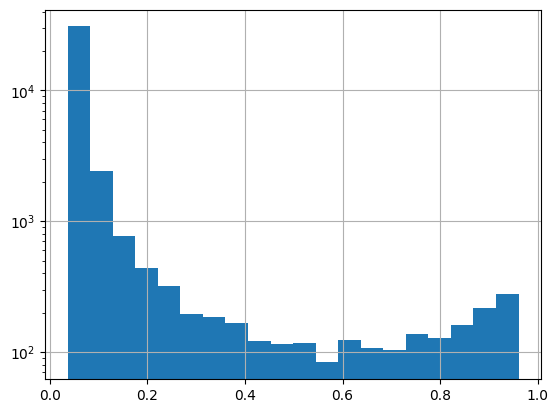

In [21]:
df['prob'].hist(bins=20, log=True)

In [22]:
df['bucket'] = (df['prob']*10).astype(int)

In [23]:
n_sample = 20

In [26]:
df_out = (
    df
    .groupby('bucket', group_keys=False)
    .apply(lambda x: x.sample(min(len(x), n_sample)))
    .sample(frac=1)
)

In [27]:
len(df_out)

200

In [28]:
df_out.bucket.value_counts()

2    20
6    20
3    20
8    20
5    20
7    20
1    20
9    20
4    20
0    20
Name: bucket, dtype: int64

Save to JSON

In [29]:
df_out

,title,url,text,dead,by,score,time,timestamp,type,parent,descendants,ranking,deleted,root,clean_text,bucket,text_length,prob
id,,,,,,,,,,,,,,,,,,
27783556,None,None,"&gt; I terms of providing value to the world at large they should have gone with Wozniak.<p>As a personality, I like Wozniak more. If I ever had a chance to meet Jobs and Wozniak in person, I suspect that I would find Wozniak to be a much better person than Jobs. That being said, I think that Jobs provided much more value to the world.<p>Wozniak&#x27;s chief contribution to the world is the Apple II. It is a wonderful computer with fun stories behind its development, but the computer industry would have gone on without it. Apple&#x27;s early years are culturally significant since it was one of the few success stories that wasn&#x27;t corporate (in contrast to the Commodore PET and Tandy TRS-80), but that story is probably the most significant part about the company.<p>Contrast that to Jobs. As a minimum, the Apple II and Macintosh can be contributed to him. Without his drive, the Apple II would likely be remembered as one of the multitude of personal computers that didn&#x27;...",None,II2II,NaN,1625838141,2021-07-09 13:42:21+00:00,comment,27781653,NaN,NaN,None,27779907,"> I terms of providing value to the world at large they should have gone with Wozniak.\n\nAs a personality, I like Wozniak more. If I ever had a chance to meet Jobs and Wozniak in person, I suspect that I would find Wozniak to be a much better person than Jobs. That being said, I think that Jobs provided much more value to the world.\n\nWozniak's chief contribution to the world is the Apple II. It is a wonderful computer with fun stories behind its development, but the computer industry would have gone on without it. Apple's early years are culturally significant since it was one of the few success stories that wasn't corporate (in contrast to the Commodore PET and Tandy TRS-80), but that story is probably the most significant part about the company.\n\nContrast that to Jobs. As a minimum, the Apple II and Macintosh can be contributed to him. Without his drive, the Apple II would likely be remembered as one of the multitude of personal computers that didn't make it in the mar...",2,1550,0.260213
27915310,None,None,From 2014. A classic.,None,emmelaich,NaN,1626927690,2021-07-22 04:21:30+00:00,comment,27915173,NaN,NaN,None,27915173,From 2014. A classic.,2,22,0.210275
29058228,None,None,"I would add that there is a trade-off in games between agency and a good story.<p>The more effort you make to integrate player actions, the less resources you have to make a compelling story. In the most obvious case: story branching, you have double the work for each branch, some of them may be hard to make interesting.<p>Some Japanese visual novels may have great stories, but they are games in name only. For example the &quot;when they cry&quot; series are literally visual novels (or sound novels as they like to call them), there are zero gameplay elements, and no branching, you are basically reading a book with a few illustrations and (very good) background music.<p>On the other side, some games focus so much on action that the only goal of the story is to tell you who the bad guys are and not get in the way of shooting them.",None,GuB-42,NaN,1635698430,2021-10-31 16:40:30+00:00,comment,29056751,NaN,NaN,None,29055167,"I would add that there is a trade-off in games between agency and a good story.\n\nThe more effort you make to integrate player actions, the less resources you have to make a compelling story. In the most obvious case: story branching, you have double the work for each branch, some of them may be hard to make interesting.\n\nSome Japanese visual novels may have great stories, but they are games in name only. For example the ""when they cry"" series are literally visual novels (or sound novels as they like to call them), there are zero gameplay elements, and no branching, you are basically reading a boo

In [30]:
import json

with open('data/02_intermediate/hn_sample_eval_bucket_3.jsonl', 'w') as f:
    for id, row in df_out.iterrows():
        data = {"text": row["clean_text"], "meta": {"id": id,
                                                    "prob_group": row.bucket,
                                                    "prob": row.prob}}
        print(json.dumps(data), file=f)